In [35]:
import numpy as np

import tensorflow as tf
import random

import os

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

import librosa
import deeplake

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE

from keras.models import load_model

import matplotlib as mpl
import matplotlib.pyplot as plt

In [36]:
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [37]:
def standardize_mfcc_length(mfcc_list, target_length=100):
    """Standardize MFCC matrices to a fixed length"""
    result = []
    for mfcc in mfcc_list:
        current_length = mfcc.shape[1]
        if current_length > target_length:
            # Truncate if longer than target
            standardized = mfcc[:, :target_length]
        else:
            # Pad with zeros if shorter
            padding = np.zeros((mfcc.shape[0], target_length - current_length))
            standardized = np.hstack([mfcc, padding])
        
        # Flatten the matrix for traditional ML models
        result.append(standardized.flatten())
    
    return np.array(result)

In [38]:
TARGET_LABELS = {"stop", "go", "up", "down", "left", "right"}

def extract_filtered_mfcc_features(dataset, n_mfcc=13, sample_rate=16000):
    """
    Extracts MFCC features only for the selected words.
    
    Parameters:
    - dataset: The Deeplake dataset containing audio tensors.
    - n_mfcc: Number of MFCC coefficients to extract.
    - sample_rate: Target sample rate for librosa processing.
    
    Returns:
    - X: NumPy array of MFCC features (num_samples, n_mfcc)
    - y: NumPy array of corresponding labels
    """
    
    X, y = [], []
    
    for i in range(len(dataset)):
        point_label = dataset.labels[i].data()['text'][0]  

        if point_label in TARGET_LABELS:  # Keep only target samples
            
            audio = dataset['audios'][i].numpy().squeeze()  # Extract audio data
            
            # Compute MFCC
            mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
            # mfcc_mean = np.mean(mfcc, axis=1)  # second method: Can take mean of factors for more simplistic feature set
            
            X.append(mfcc)
            y.append(point_label)
            
    return standardize_mfcc_length(X), np.array(y)

In [39]:
# Load dataset
dataset = deeplake.load('hub://activeloop/speech-commands-train')

# Extract features
X, y = extract_filtered_mfcc_features(dataset)


-

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/speech-commands-train



/

hub://activeloop/speech-commands-train loaded successfully.



In [40]:


# Scale features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balance dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# Encode labels so they are ints instead of strings for training the model
label_encoder = LabelEncoder()

# Convert string labels to integers
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)  # Use the same encoder to transform test labels

# Check class mapping
print(dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))


# Get amount of labels for output layer of neural network (how many classes we are distinguishing)
unique_labels = np.unique(y_train)  
highest_label = np.max(unique_labels)





{'down': 0, 'go': 1, 'left': 2, 'right': 3, 'stop': 4, 'up': 5}


In [41]:
# Referenced:  https://www.tensorflow.org/tutorials/images/cnn
model = models.Sequential()
model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(1300, 1)))


In [42]:
# Add dense layers on top
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(highest_label + 1))

In [43]:
#Compile and train model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, 
                    validation_data=(X_test, y_test))

Epoch 1/100
357/357 [==============================] - 25s 65ms/step - loss: 0.9314 - accuracy: 0.6724 - val_loss: 0.6477 - val_accuracy: 0.7717
Epoch 2/100
357/357 [==============================] - 18s 51ms/step - loss: 0.5123 - accuracy: 0.8213 - val_loss: 0.5205 - val_accuracy: 0.8256
Epoch 3/100
357/357 [==============================] - 18s 52ms/step - loss: 0.3555 - accuracy: 0.8759 - val_loss: 0.4377 - val_accuracy: 0.8473
Epoch 4/100
357/357 [==============================] - 22s 60ms/step - loss: 0.2560 - accuracy: 0.9119 - val_loss: 0.4323 - val_accuracy: 0.8526
Epoch 5/100
357/357 [==============================] - 38s 107ms/step - loss: 0.1980 - accuracy: 0.9320 - val_loss: 0.4532 - val_accuracy: 0.8508
Epoch 6/100
357/357 [==============================] - 27s 74ms/step - loss: 0.1532 - accuracy: 0.9489 - val_loss: 0.4511 - val_accuracy: 0.8652
Epoch 7/100
357/357 [==============================] - 26s 72ms/step - loss: 0.1133 - accuracy: 0.9624 - val_loss: 0.5265 - val_a

90/90 - 1s - loss: 1.7556 - accuracy: 0.8263 - 794ms/epoch - 9ms/step
90/90 [==============================] - 1s 8ms/step

Convolutional Neural Network Model Performance:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       476
           1       0.85      0.74      0.79       476
           2       0.77      0.82      0.79       476
           3       0.90      0.86      0.88       476
           4       0.92      0.86      0.89       476
           5       0.73      0.85      0.79       476

    accuracy                           0.83      2856
   macro avg       0.83      0.83      0.83      2856
weighted avg       0.83      0.83      0.83      2856

Accuracy: 0.8263305322128851


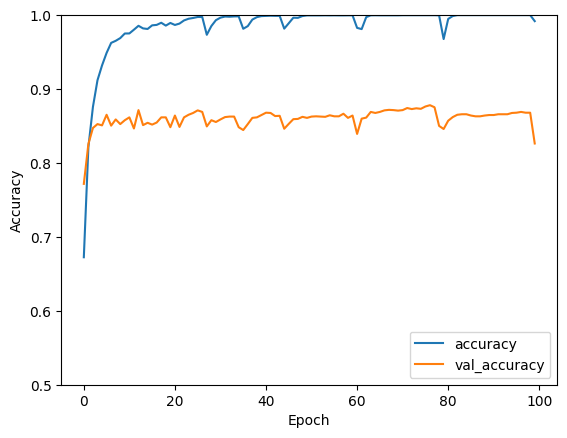

In [44]:
# Evaluate the model
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)


from sklearn.metrics import classification_report, accuracy_score

# Get model predictions (logits)
y_pred_logits = model.predict(X_test)  # This will return raw logits

# Convert logits to class labels (since from_logits=True)
y_pred = np.argmax(y_pred_logits, axis=1)

# Print classification report
print("\nConvolutional Neural Network Model Performance:")
print(classification_report(y_test, y_pred))

# Compute accuracy separately
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)



In [45]:

model.save('cnn_model.h5')
print("CNN model saved to cnn_model.h5")

c:\Users\Toazt\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


CNN model saved to cnn_model.h5


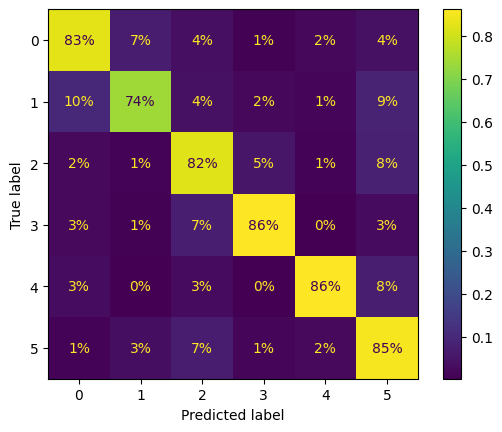

In [46]:
# Show confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

plt.rc('font', size=10)  
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        normalize="true", values_format=".0%")
plt.show()

New number of features / dimension size:  139


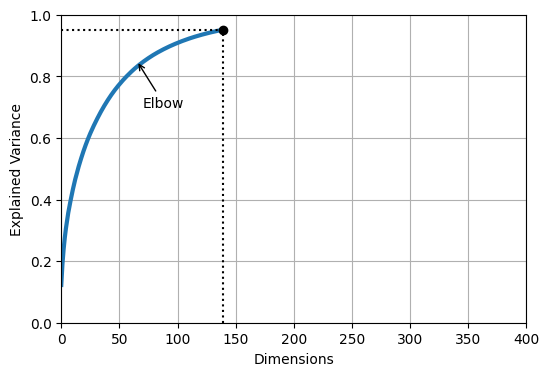

In [47]:
# Reduce features using PCA
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_resampled)


# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# Encode labels so they are ints instead of strings for training the model
label_encoder = LabelEncoder()

# Convert string labels to integers
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)  # Use the same encoder to transform test labels



cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

print("New number of features / dimension size: ", d)

plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
plt.show()

In [48]:
# Referenced:  https://www.tensorflow.org/tutorials/images/cnn
pca_model = models.Sequential()
pca_model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(139, 1)))

pca_model.add(layers.Flatten())
pca_model.add(layers.Dense(64, activation='relu'))
pca_model.add(layers.Dense(highest_label + 1))


In [49]:
# Train model again using reduced features

#Compile and train model
pca_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

pca_history = pca_model.fit(X_train, y_train, epochs=100, 
                    validation_data=(X_test, y_test))


Epoch 1/100
357/357 [==============================] - 6s 11ms/step - loss: 0.9984 - accuracy: 0.6446 - val_loss: 0.7763 - val_accuracy: 0.7265
Epoch 2/100
357/357 [==============================] - 4s 11ms/step - loss: 0.5991 - accuracy: 0.7965 - val_loss: 0.5346 - val_accuracy: 0.8088
Epoch 3/100
357/357 [==============================] - 3s 10ms/step - loss: 0.3902 - accuracy: 0.8711 - val_loss: 0.4678 - val_accuracy: 0.8358
Epoch 4/100
357/357 [==============================] - 3s 10ms/step - loss: 0.2703 - accuracy: 0.9098 - val_loss: 0.4222 - val_accuracy: 0.8557
Epoch 5/100
357/357 [==============================] - 4s 12ms/step - loss: 0.1924 - accuracy: 0.9350 - val_loss: 0.4156 - val_accuracy: 0.8666
Epoch 6/100
357/357 [==============================] - 4s 12ms/step - loss: 0.1432 - accuracy: 0.9505 - val_loss: 0.4882 - val_accuracy: 0.8589
Epoch 7/100
357/357 [==============================] - 3s 8ms/step - loss: 0.0991 - accuracy: 0.9684 - val_loss: 0.4884 - val_accuracy: 

90/90 - 0s - loss: 1.9640 - accuracy: 0.8764 - 466ms/epoch - 5ms/step
90/90 [==============================] - 1s 6ms/step

Convolutional Neural Network Model Performance With PCA:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85       476
           1       0.87      0.88      0.87       476
           2       0.88      0.87      0.87       476
           3       0.91      0.90      0.91       476
           4       0.90      0.91      0.90       476
           5       0.84      0.85      0.85       476

    accuracy                           0.88      2856
   macro avg       0.88      0.88      0.88      2856
weighted avg       0.88      0.88      0.88      2856

Accuracy: 0.8764005602240896


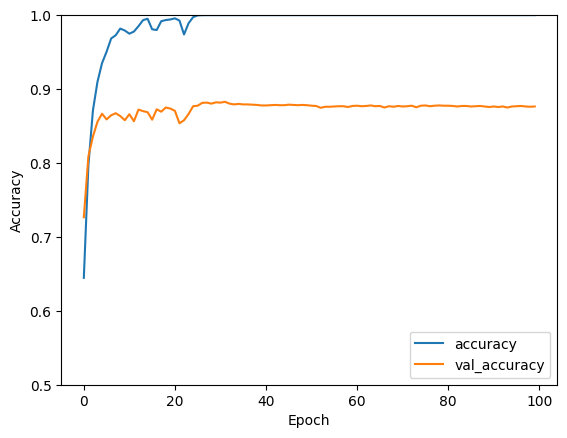

In [50]:
# Evaluate the model
plt.plot(pca_history.history['accuracy'], label='accuracy')
plt.plot(pca_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = pca_model.evaluate(X_test,  y_test, verbose=2)


from sklearn.metrics import classification_report, accuracy_score

# Get model predictions (logits)
y_pred_logits = pca_model.predict(X_test)  # This will return raw logits

# Convert logits to class labels (since from_logits=True)
y_pred = np.argmax(y_pred_logits, axis=1)

# Print classification report
print("\nConvolutional Neural Network Model Performance With PCA:")
print(classification_report(y_test, y_pred))

# Compute accuracy separately
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)



In [51]:
# Save model
pca_model.save('pca_cnn_model.h5')
print("PCA CNN model saved to pca_cnn_model.h5")

PCA CNN model saved to pca_cnn_model.h5


c:\Users\Toazt\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


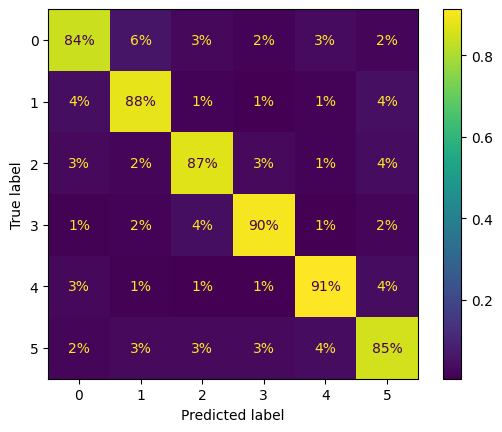

In [52]:
# Show confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

plt.rc('font', size=10)  
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        normalize="true", values_format=".0%")
plt.show()